# A study of a simple parabolic motion

This python notebook will explore how python and its various tools (NumPy, SciPy, Matplotlib, etc) can be used to study physics problems, using a very simple and well known example: the parabolic motion.

First of all, let's include some modules:

In [75]:
%matplotlib inline
# the above line just lets matplotlib plot directly in the notebook

# import Numpy, for dealing with data arrays
import numpy as np

# import matplotlib, for plotting figures
import matplotlib.pyplot as plt

# import the mathematical library
import math

## Modeling the trajectory

The trajectory equation for the parabolic motion is well known, and it is:

$$
y = x \tan(\theta) - \frac{g}{2 v_0^2 (\cos{\theta})^2} x^2
$$

It is pretty simple to represent it in python:

In [76]:
theta = math.radians(20) # in radians (converted from degrees)
v_0 = 20  # in m/s
g = 9.81  # in m/s**2

x = np.arange(0, 10, 0.1)  # array of x coordinates in meters
# the trajectory equation
y = x * math.tan(theta) - (g / (2 * v_0**2 * math.cos(theta)**2)) * x**2

To plot it, we create a figure with a certain size, plot `x` and `y`, and also set up some axis labels:

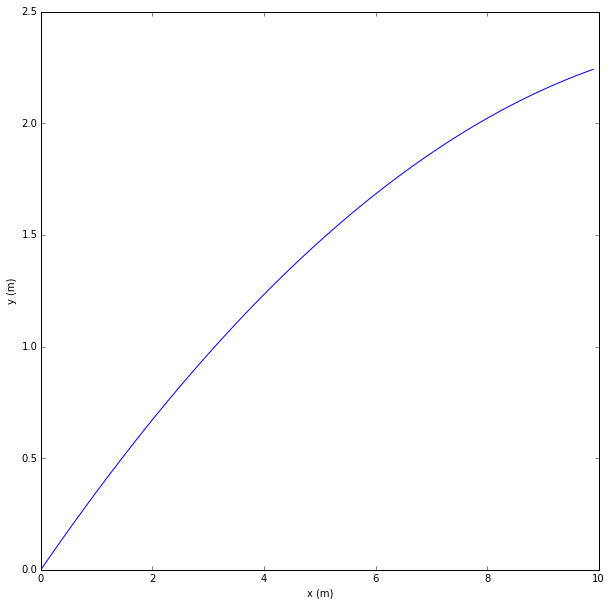

In [77]:
plt.figure(figsize=(10,10))  # the figure
plt.plot(x, y)  # plotting y in function of x
plt.xlabel("x (m)")  # x label
plt.ylabel("y (m)")  # y label
plt.show()  # actually creating the figure

We can plot the trajectory for various values of $\theta$. To do this in an efficienty way, we define a function that returns the parabolic trajectory, taking as inputs the values of $x$, $g$, $v_0$ and $\theta$

In [78]:
def get_y(x, a, v_0, t):
    """
    Simple function to compute y in a parabolic motion
    
    :param x: a numpy array with the X coordinates in meters
    :param a: the acceleration in m/s**2
    :param v_0: the initial velocity in m/s
    :param theta: the initial theta angle in degrees(default=10) 
    """
    
    theta = math.radians(t)
    y = x * math.tan(theta) - (a / (2 * v_0**2 * math.cos(theta)**2)) * x**2
    return y

Then we create a list of values for $\theta$, and plot the various trajectories

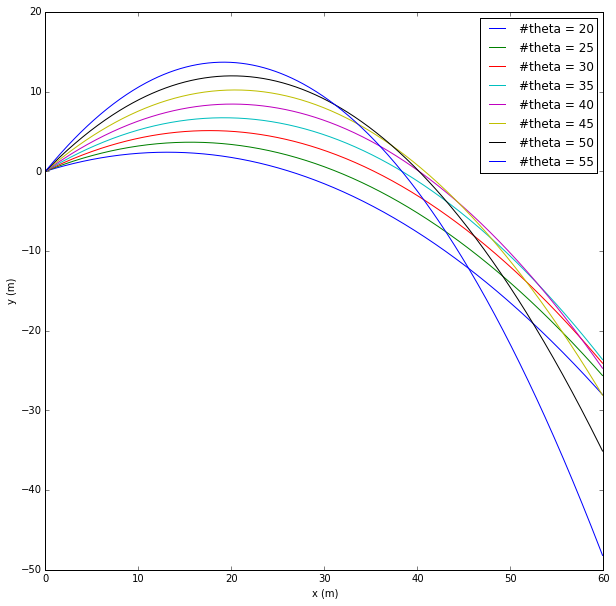

In [79]:
thetas = [t for t in np.arange(20, 60, 5)]
x = np.arange(0, 60, 0.1)  # in meters

plt.figure(figsize=(10, 10))
for t in thetas:
    y = get_y(x, g, v_0, t=t)
    plt.plot(x, y, label="#theta = " + str(t))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    
plt.legend(loc="best")
plt.show()

## Numerical computation of the maximum range (brute force)

What if we want to find the $\theta$ value for which we do have the maximum range? In this case, we need to modify our function a bit. If we want to keep it generic (so that we can still set up different accelerations, initial velocities),we need to wrap it up in a `class` (similar to `C++` classes). 

In more details:

* the special `__init__` method is called when you create a new instance of the class, e.g. by doing:
```
f = Parabolic(a, v, t)
```
this is how you pass attributes to the class (in this case, acceleration, initial velocity and the angle)

* the special `__call__` method allows you to use the class instance as a function. In this case, when doing `f(t)` you are calling the method defined in `__call__`, which in this case is simply the trajectory function

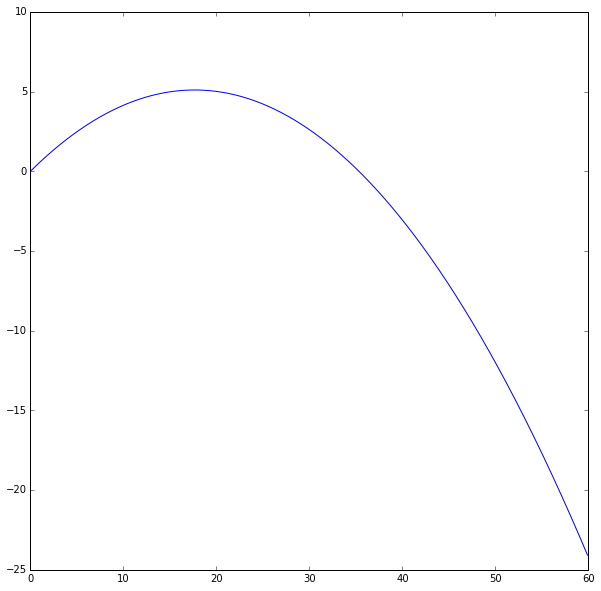

In [80]:
# defining the class
class ParabolicF(object):
    """
    Simple class defining a parabolic trajectory
    """
        
    # the special initialization method:
    def __init__(self, a, v_0, t):
        """
        Setting the parameters for the trajectory function
        """
        self.a = a
        self.v_0 = v_0
        self.t = math.radians(t)
    
    # the method called when the object is called as a function
    def __call__(self, x):
        """
        Returns the y values for a parabolic trajectory, given x
        """
        y = x * math.tan(self.t) - (self.a / (2 * v_0**2 * math.cos(self.t)**2)) * x**2
        return y

# creating an object
f = ParabolicF(g, v_0, 30)
plt.figure(figsize=(10,10))
# using the object as a function
plt.plot(x, f(x))
plt.show()

Why are we doing this? Because we want to use `scipy.optimize.root` to find the roots of our trajectory, and as it is clear from the help, it needs a function as an argument:

In [81]:
from scipy import optimize
help(optimize.root)

Help on function root in module scipy.optimize._root:

root(fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None)
    Find a root of a vector function.
    
    Parameters
    ----------
    fun : callable
        A vector function to find a root of.
    x0 : ndarray
        Initial guess.
    args : tuple, optional
        Extra arguments passed to the objective function and its Jacobian.
    method : str, optional
        Type of solver.  Should be one of
    
            - 'hybr'
            - 'lm'
            - 'broyden1'
            - 'broyden2'
            - 'anderson'
            - 'linearmixing'
            - 'diagbroyden'
            - 'excitingmixing'
            - 'krylov'
    
    jac : bool or callable, optional
        If `jac` is a Boolean and is True, `fun` is assumed to return the
        value of Jacobian along with the objective function. If False, the
        Jacobian will be estimated numerically.
        `jac` can also be a callable ret

One option would have been to create `N` functions to test `N` values of $\theta$, but this requires a lot of cut & paste and is not very efficient. While, with the class we created, now it's a matter of a simple loop:

In [82]:
results = []  # list that will contain our results

# loop on thetas
for t in thetas:
    f1 = ParabolicF(g, v_0, t)  # creating the object
    root = optimize.root(f1, [0, 1000], method="hybr")  # getting the roots
    results.append(root.x[-1])  # using only the last root, as we know the first one is zero

# printing the maximum value, and the correspondant theta
# np.argmax is a NumPy utility that returns the index of the maximum value
print "Maximum is %.2f meters for theta=%.2f" % (np.max(results), thetas[np.argmax(results)])

Maximum is 40.77 meters for theta=45.00


## Numerical computation of maximum range

We can solve the maximum range problem also analytically. The range is defined by this set of equations:

$$
\begin{eqnarray}
y &=& 0 \\
x &=& \frac{v_0^2 \sin{2\theta}}{g} \\
\end{eqnarray}
$$

One option is to compute the derivative numerically, and then find its maximum. `scipy.misc.derivative` can compute derivatives (order 1 or higher) for a specific point, so we do have to loop:

Maximum range is for 45.00 degrees


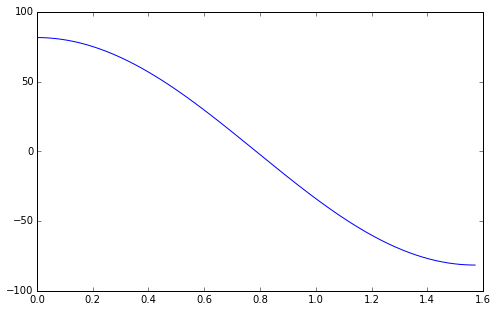

In [134]:
from scipy import misc

# defining our parabilic function, this time with fixed parameters
def f_range(theta):
    v_0 = 20
    g = 9.81
    x = ( v_0**2 * math.sin(2 * theta)) / g
    return x

# a thin-grained list of thetas
thetas = np.arange(0, math.pi / 2., 0.0001)
results = []
# the loop over derivatives
for t in thetas:
    results.append(misc.derivative(f_range, t, dx=1e-9,))
    
# creates a numpy array with all the theta, f' couples
r = np.array(zip(thetas, results))

# find the element closest to 0, which is where range is maximum
min_val = r[np.isclose(r[:, 1], 0, atol=1e-03)]

print "Maximum range is for %.2f degrees" % np.degrees(min_val[:, 0])[0]

# plot the derivative
plt.figure(figsize=(8,5))
plt.plot(thetas, results)
plt.show()

A bit of explanation:

---
```
r = np.array(zip(thetas, results))
```

`zip` takes two sequences, and create a list of tuples, where the i-th tuple contains the i-th element from each of the sequences. In this case it creates a list like `[(theta_1, deriv_1), ..., (theta_n, deriv_n)]`. From this, we can directly create a numpy array, where the rows are the pairs $[\theta_i, f'(\theta_i)]$


---

```
min_val = r[np.isclose(r[:, 1], 0, atol=1e-04)]
```
As we do not have the derivative as a function, but just as a list of values, we need to find the element closest to 0. We can use using np.isclose for that (atol is the tolerance). `np.isclose(r[:, 1], 0, atol=1e-04)` means:

* `r[:1]`: take the second column of the array and
* `np.isclose(r[:, 1], 0, atol=1e-04)`: find the values there which are close to $0$ within a tolerance of $1 e^{-4}$




## Full analytical computation of maximum range

Python is not just brute force computations... you can also do **symbolic computations**, using `SymPy`. For not too complex functions, an analytical derivative can be computed, and then using `scipy.optimize.root` we can find its roots.

The derivative is:  81.5494393476045*cos(2*theta)
The maximum range is for theta:  [ 45.]  degrees


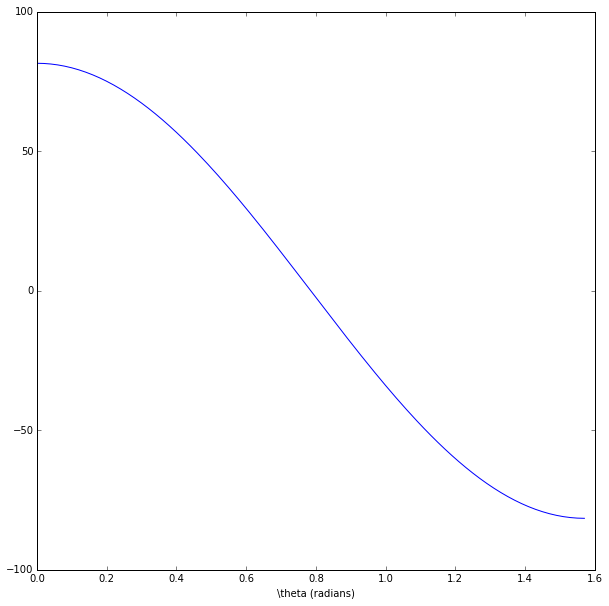

In [147]:
import sympy

# define theta as a special SymPy symbol
theta = sympy.Symbol("theta")

# usual parameters
v_0 = 20
g = 9.81

# the function to be derived. NB: we have to use sympy.sin instead of math.sin, as we are performin symbolic computations
x = ( v_0**2 * sympy.sin(2 * theta)) / g

# the derivative operation
xprime = x.diff(theta)
print "The derivative is: ", xprime

# lambdify transforms SymPy expressions in lambda functions, that we can use to do further computations
fprime = sympy.lambdify(theta, xprime, 'numpy')

# let's find the roots
thetas2 = np.arange(0, math.pi / 2., 0.01)
roots = np.degrees(optimize.root(fprime, 0.5, method="hybr").x)
print "The maximum range is for theta: ", roots, " degrees"

# and plotting again the derivative
plt.figure(figsize=(10, 10))
plt.plot(thetas2, fprime(thetas2))
plt.xlabel(r"theta (radians)")
plt.xlabel(r"x_prime(theta) ")
plt.show()
